In [247]:
from math import radians, sin, cos
import math
from numpy.random import randn, randint, random, uniform
#from numpy.random import randint
import matplotlib.pyplot as plt
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.interpolate import interp1d


In [3]:
def fx(x,t):
    return fx.vel

def fy(y,t):
    return fy.vel

def fz(z,t):
    return fz.vel

In [4]:
def rk4(y, x, dx, f):
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

In [5]:
def time_fly(d):
    return(1.03911548e-03*d+9.67602872e-08*d**2+1.51747496e-11*d**3)

In [150]:
def dot_kf_3d(r0, zen, az, v0, dt, r=0.5, q=0.):
    az = radians(az)
    zen = radians(zen)
    x = r0*math.sin(zen)*math.cos(az)
    y = r0*math.sin(zen)*math.sin(az)
    z = r0*math.cos(zen)
    kf = KalmanFilter(dim_x=6, dim_z=3)

    kf.F = np.array([[1., dt, 0., 0., 0., 0.],   # x   = x0 + dx*dt
                     [0., 1., 0., 0., 0., 0.],   # dx  = dx0
                     [0., 0., 1., dt, 0., 0.],   # y   = y0 + dy*dt
                     [0., 0., 0., 1., 0., 0.],   # dy  = dy0
                     [0., 0., 0., 0., 1., dt],   # y   = y0 + dy*dt
                     [0., 0., 0., 0., 0., 1.]])  # dz  = dz0

    kf.H = np.array([[1., 0., 0., 0., 0., 0.],
                     [0., 0., 1., 0., 0., 0.],
                     [0., 0., 0., 0., 1., 0.]])
    
    #kf.B = np.array([[0., 0., 0., dt]]).T
    kf.R *= r
    kf.Q *= q


    vx = cos(az) * v0 * sin(zen)
    vy = sin(az) * v0 * sin(zen)
    vz = v0 * cos(zen)
    kf.x = np.array([[x, vx, y, vy, z, vz]]).T
    return kf

In [151]:
def gen_mission(cou, t, path):
    i=0
    txt_file = open(path, "w")
    txt_file.write(str(t)+"\n") #среднее время одного маневра
    while i<cou:
        a=randint(1,4) #1-прямолинеййное, 2-поворот 0-90, 3-разворот 90-360
        b=randint(1,4)
        txt_file.write(str(a)+"\n")
        txt_file.write(str(b)+"\n")
        i+=1
    txt_file.close()


In [164]:
class Trajectory3D1(object):
    def __init__(self, r0=0., zen0_deg=0., az0_deg=90., velocity=0, 
                                 noise=[0.0, 0.0, 0.0]):
        self.az = math.radians(az0_deg) #азимут\бывшая тета
        self.zen = math.radians(zen0_deg) #зенит\бывшая фи
        self.x = r0*math.sin(self.zen)*math.cos(self.az)
        self.y = r0*math.sin(self.zen)*math.sin(self.az)
        self.z = r0*math.cos(self.zen)
        self.t = 0        
        self.velocity=velocity
        self.noise = noise  
        self.xm=[]
        self.ym=[]
        self.zm=[]
        self.vm=[]
        self.tm=[]
        self.xm.append(self.x)
        self.ym.append(self.y)
        self.zm.append(self.z)
        self.vm.append(self.velocity)
        self.tm.append(0)
        #self.rm=[]
        self.zenm=[]
        self.azm=[] 
        self.zenm.append(self.zen)
        self.azm.append(self.az)
        
    def move(self, alfa_deg, beta_deg, dt, t):
        xm=[]
        ym=[]
        zm=[]
        alfa = math.radians(alfa_deg)
        beta = math.radians(beta_deg)
        tmp_t=0
        acc=randint(-100,100)*0.3
        while (tmp_t<t):
            #print(self.phi)
            self.az+=alfa
            self.zen+=beta
            if (self.velocity+acc<=50):
                acc=np.abs(acc)
            self.velocity+=acc
            fx.vel = math.cos(self.az) * (self.velocity) * math.sin(self.zen)
            fy.vel = math.sin(self.az) * (self.velocity) * math.sin(self.zen)
            fz.vel = math.cos(self.zen) * (self.velocity)
            self.x = rk4(self.x, self.t, dt, fx)+ randn() * self.noise[0]
            self.y = rk4(self.y, self.t, dt, fy)+ randn() * self.noise[1]
            self.z = rk4(self.z, self.t, dt, fz) + randn() * self.noise[2]
            self.t += dt
            tmp_t += dt
            self.xm.append(self.x)
            self.ym.append(self.y)
            self.zm.append(self.z)
            self.vm.append(self.velocity)
            self.tm.append(self.t)
            self.zenm.append(self.zen)
            self.azm.append(self.az)

    def mission(self,path):
        temp=np.loadtxt(path)
        i=1
        t=int(temp[0])
        while i<len(temp)-1:
            tmp_m=int(temp[i])
            tmp_z=int(temp[i+1])
            i+=2
            
            if tmp_m==1:
                alfa=0
            if tmp_m==2:
                alfa=randint(-90,90)/t
            if tmp_m==3:
                alfa=randint(90,360)/t
        
            if tmp_z==1:
                beta=randint(-9,0)
            if tmp_z==2:
                beta=0
            if tmp_z==3:
                beta=randint(0,9)
            self.move(alfa, beta,0.5,t) 
    '''def to_sph(self):
        self.rm=[]
        self.zenm=[]
        self.azm=[]'''
    
        

In [244]:
def track_dot_3dm(q, r=1., noise=0.3):
    dt=0.5
    
    rad,az, zen = 1000., 45.,45. # launch
    v0 = 100.

    
    tochka4 = Trajectory3D1(r0=rad, zen0_deg=zen, az0_deg=az, velocity=v0, 
                                 noise=[0.05, 0.05, 0.05])
    tochka4.mission("1.txt")
    kf = dot_kf_3d(rad, zen, az,v0, dt, r=r, q=q)

    t = 0
    xs, ys, zs = [], [], []
    i=0
    
    miss_mas=[]
    fig = plt.figure()
    
    ax1 = fig.add_axes([0.0, 0, 1, 1]) 
    ax1.set_title(u'XY')
    
    ax2 = fig.add_axes([0.0, -1.25, 1, 1]) 
    ax2.set_title(u'XZ')
    
    ax3 = fig.add_axes([1.25, 0, 1, 1]) 
    ax3.set_title(u'YZ')
    #интерполяция движения для последующего сравнения..............................
    f1x=interp1d(tochka4.tm,tochka4.xm) #x
    f1y=interp1d(tochka4.tm,tochka4.ym) #y
    f1z=interp1d(tochka4.tm,tochka4.zm) #z
    #..............................................................................
    while (i<len(tochka4.xm)):
        t += dt
        
        z = np.array([[tochka4.xm[i], tochka4.ym[i], tochka4.zm[i]]]).T
        
        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])
        zs.append(kf.x[4])
        kf.predict()   
        #построение траектории измерений
        p11 = ax1.scatter(tochka4.xm[i], tochka4.ym[i], color='r', marker='.', s=75, alpha=0.5)        
        p11 = ax1.scatter(tochka4.xm[0], tochka4.ym[0], color='g', marker='o', s=75, alpha=0.5)
                
        p12 = ax2.scatter(tochka4.xm[i], tochka4.zm[i], color='r', marker='.', s=75, alpha=0.5)        
        p12 = ax2.scatter(tochka4.xm[0], tochka4.zm[0], color='g', marker='o', s=75, alpha=0.5)
                
        p13 = ax3.scatter(tochka4.ym[i], tochka4.zm[i], color='r', marker='.', s=75, alpha=0.5)
        p13 = ax3.scatter(tochka4.ym[0], tochka4.zm[0], color='g', marker='o', s=75, alpha=0.5)
        
        #расчет расстояния от 0,0,0 до текущего местоположения
        d=math.sqrt(tochka4.xm[i]**2+tochka4.ym[i]**2+tochka4.zm[i]**2)
        #если меньше 6к, то предсказываем, где точка будет через время полета снаряда с текущей скоростью и направлением
        #строим предсказанное желтым
        #предсказываем
        x_pre = tochka4.xm[i] + time_fly(d) * tochka4.vm[i] * math.cos(tochka4.azm[i]) * math.sin(tochka4.zenm[i])
        y_pre = tochka4.ym[i] + time_fly(d) * tochka4.vm[i] * math.sin(tochka4.azm[i]) * math.sin(tochka4.zenm[i])
        z_pre = tochka4.zm[i] + time_fly(d) * tochka4.vm[i] * math.cos(tochka4.zenm[i])
        if (d<6000) and (tochka4.tm[i]+time_fly(d)<tochka4.t):
            p11 = ax1.plot([tochka4.xm[i], x_pre], 
                       [tochka4.ym[i], y_pre],
                       color ='y')
            p12 = ax2.plot([tochka4.xm[i], x_pre], 
                       [tochka4.zm[i], z_pre],
                       color ='y')
            p13 = ax3.plot([tochka4.ym[i], y_pre], 
                       [tochka4.zm[i], z_pre],
                       color ='y')
            miss_mas.append([f1x(tochka4.tm[i]+time_fly(d))-x_pre,f1y(tochka4.tm[i]+time_fly(d))-y_pre,
                             f1z(tochka4.tm[i]+time_fly(d))-z_pre])
        else:
            miss_mas.append(['far'])
        i+=1
    p21 = ax1.plot(xs, ys, lw=2)
    p22 = ax2.plot(xs, zs, lw=2)
    p23 = ax3.plot(ys, zs, lw=2)
    return (miss_mas,tochka4.tm,tochka4.vm, tochka4.xm, tochka4.ym, tochka4.zm)
    #ax1.legend([p21, p11], ['Kalman filter', 'Measurements'],
           #    scatterpoints=1)
    

In [189]:
gen_mission(1,10,"1.txt")

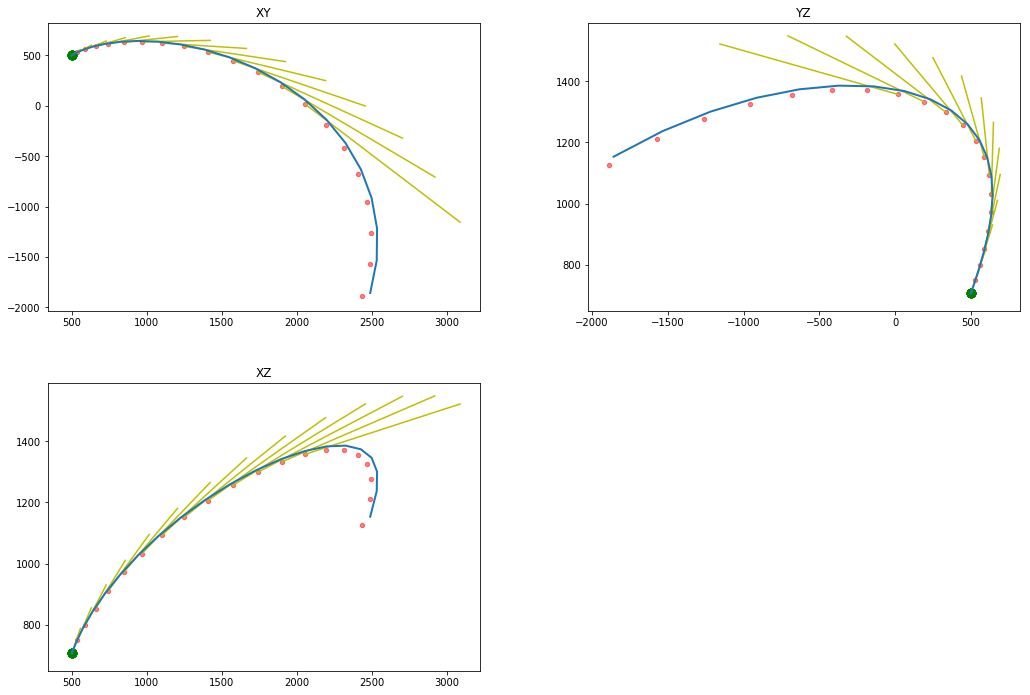

In [245]:
mm,t,v,x,y,z=track_dot_3dm(0.5, noise=0.3)

In [246]:
mm

[[53.02605573455753, 11.588462958693412, 27.063751894534334],
 [67.88657838511278, 0.2310745502215923, 24.660509672990997],
 [83.34463237645741, -17.064600837524495, 21.154498214526825],
 [97.99865990008095, -41.3154063647263, 16.03363177205506],
 [111.76877046778077, -77.1292712262109, 8.198521426389334],
 [120.28092476365441, -125.61603005023824, -3.3316534456027966],
 [117.9015771076165, -184.4192388428694, -19.19075500555323],
 [100.30108631102257, -256.37323996374005, -40.98130167208683],
 [60.33416202461581, -340.47748365532277, -70.84411792544302],
 [-5.532834119862855, -425.5087116723515, -107.54413372865747],
 [-109.32335513213411, -514.2083064334597, -157.00153901148678],
 [-247.4978780661445, -587.6069589421109, -215.87401946682644],
 [-426.7602683573764, -637.6579665398019, -288.44104983900775],
 [-640.1631112158329, -649.1200536975689, -373.79042226800834],
 ['far'],
 ['far'],
 ['far'],
 ['far'],
 ['far'],
 ['far'],
 ['far']]

In [ ]:
def gpz(str_c,trn_c,ta_c):
    #генерируем стартовую позицию на границе сферы
    r0=6000
    az0=uniform(0,360)
    zen0=uniform(-70, 70)
    
    
    

In [264]:
uniform(0,6000)

1245.2373122141105

In [270]:
math.degrees(math.asin(1/300))

0.19098628538969414

In [269]:
math.degrees(math.pi)

180.0